# Soft Computing

## Vežba 3 - HOG

## Histogram of Oriented Gradients (HOG)

Jedan od najpopularnijih postupaka za izdvajanje osobina (eng. *feature extraction*) sa digitalne slike. Formalno, HOG je nešto što se zove **deskriptor slike** (eng. *image descriptor*), koji predstavlja opis vizuelnih osobina slike. Iako je predstavljen pre više od jedne dekade, tačnije 2005. godine u radu <a href="http://lear.inrialpes.fr/people/triggs/pubs/Dalal-cvpr05.pdf">Histogram of Oriented Gradients for Human Detection</a>, HOG je deskriptor koji se i dan-danas vrlo često koristi za probleme detekcije i prepoznavanja objekata na slikama.

<img src="images/hog_diagram.png">

## Support Vector Machine (SVM)

SVM je model nadgledanog mašinskog učenja, koji se može koristiti za probleme klasifikacije i regresije. Ugrubo, SVM klasifikator konstruiše hiperravan koja "najbolje" razdvaja klase podataka, a ova "najbolja" hiperravan je zapravo ona koja maksimizuje marginu između podataka različitih klasa.

U svom osnovnom obliku, SVM je linearni klasifikator, tj. može vrlo efikasno da pronađe hiperravan koja maksimizuje marginu između linearno separabilnih podataka. Međutim, korišćenjem tzv. kernel trika (eng. *kernel trick*), moguće je konstruisati SVM za klasifikaciju podataka koji nisu linearno separabilni - tačnije, pomoću kernela se ulazni podaci zapravo mapiraju na neki višedimenzionalni prostor gde ti podaci postanu linearno separabilni. 

<img src="images/svm.png">

## Detekcija automobila

HOG i SVM ćemo iskoristiti kako bi rešili problem detekcije automobila na slikama iz <a href="http://cogcomp.org/Data/Car/">UIUC Image Database for Car Detection</a> skupa podataka. 

Trening skup **data/CarData/TrainImages** sadrži 1050 slika (pozitivnih i negativnih primera) dimenzija 100 x 40 za obučavanje i validaciju deskriptora i klasifikatora.

Test skup **data/CarData/TestImages** sadrži 170 slika različitih dimenzija za evaluaciju rada deskriptora i klasifikatora.

Rezultati rada deskriptora i klasifikatora na testnom skupu podataka se mogu uporediti sa tačnim lokacijama automobila koji se nalaze u **data/CarData/trueLocations.txt**.

### Obučavanje

In [1]:
import os
import numpy as np
import cv2 # OpenCV
from sklearn.svm import SVC # SVM klasifikator
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier # KNN
from joblib import dump, load
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
# prikaz vecih slika 
matplotlib.rcParams['figure.figsize'] = 16,12

In [2]:
def load_image(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2GRAY)

def display_image(image):
    plt.imshow(image, 'gray')

#### Primer pozitivnog uzorka - jeste automobil

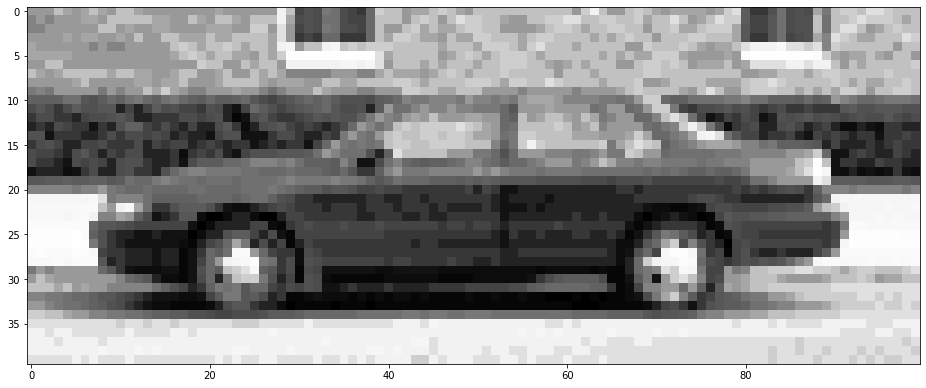

In [3]:
ipos = load_image('data/CarData/TrainImages/pos-0.pgm')
display_image(ipos)

In [4]:
ipos.shape

(40, 100)

##### Primer negativnog uzorka - nije automobil

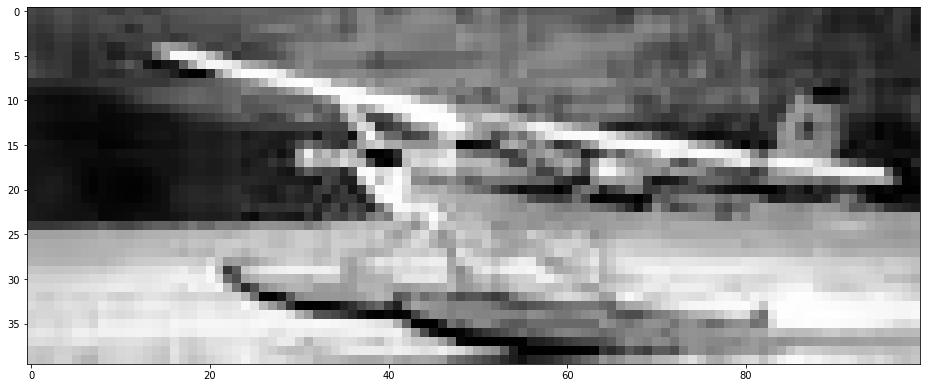

In [5]:
ineg = load_image('data/CarData/TrainImages/neg-0.pgm')
display_image(ineg)

In [6]:
ineg.shape

(40, 100)

#### Učitavanje svih primera

In [7]:
train_dir = 'data/CarData/TrainImages/'

pos_imgs = []
neg_imgs = []

for img_name in os.listdir(train_dir):
    img_path = os.path.join(train_dir, img_name)
    img = load_image(img_path)
    if 'pos' in img_name:
        pos_imgs.append(img)
    elif 'neg' in img_name:
        neg_imgs.append(img)
        
print("Positive images #: ", len(pos_imgs))
print("Negative images #: ", len(neg_imgs))

Positive images #:  550
Negative images #:  500


#### Izračunavanje HOG deskriptora za sve slike i formiranje niza labela (1 = jeste automobil, 0 = nije automobil)

In [8]:
pos_features = []
neg_features = []
labels = []

nbins = 9 # broj binova
cell_size = (8, 8) # broj piksela po celiji
block_size = (3, 3) # broj celija po bloku

hog = cv2.HOGDescriptor(_winSize=(img.shape[1] // cell_size[1] * cell_size[1], 
                                  img.shape[0] // cell_size[0] * cell_size[0]),
                        _blockSize=(block_size[1] * cell_size[1],
                                    block_size[0] * cell_size[0]),
                        _blockStride=(cell_size[1], cell_size[0]),
                        _cellSize=(cell_size[1], cell_size[0]),
                        _nbins=nbins)

for img in pos_imgs:
    pos_features.append(hog.compute(img))
    labels.append(1)

for img in neg_imgs:
    neg_features.append(hog.compute(img))
    labels.append(0)

pos_features = np.array(pos_features)
neg_features = np.array(neg_features)
x = np.vstack((pos_features, neg_features))
y = np.array(labels)

#### Podela trening skupa na trening i validacioni 

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
print('Train shape: ', x_train.shape, y_train.shape)
print('Test shape: ', x_test.shape, y_test.shape)

Train shape:  (840, 2430, 1) (840,)
Test shape:  (210, 2430, 1) (210,)


In [10]:
# transformisemo u oblik pogodan za scikit-learn
def reshape_data(input_data):
    nsamples, nx, ny = input_data.shape
    return input_data.reshape((nsamples, nx*ny))

x_train = reshape_data(x_train)
x_test = reshape_data(x_test)

In [11]:
print('Train shape: ', x_train.shape, y_train.shape)
print('Test shape: ', x_test.shape, y_test.shape)

Train shape:  (840, 2430) (840,)
Test shape:  (210, 2430) (210,)


#### Obučavanje i validacija SVM klasifikatora

In [12]:
clf_svm = SVC(kernel='linear', probability=True) 
clf_svm.fit(x_train, y_train)
y_train_pred = clf_svm.predict(x_train)
y_test_pred = clf_svm.predict(x_test)
print("Train accuracy: ", accuracy_score(y_train, y_train_pred))
print("Validation accuracy: ", accuracy_score(y_test, y_test_pred))

Train accuracy:  1.0
Validation accuracy:  1.0


#### Obučavanje i validacija KNN klasifikatora

In [13]:
clf_knn = KNeighborsClassifier(n_neighbors=10)
clf_knn = clf_knn.fit(x_train, y_train)

Serijalizacija KNN modela

In [14]:
dump(clf_knn, 'knn.joblib')

['knn.joblib']

Učitavanje KNN modela

In [15]:
clf_knn = load('knn.joblib')

In [16]:
y_train_pred = clf_knn.predict(x_train)
y_test_pred = clf_knn.predict(x_test)
print("Train accuracy: ", accuracy_score(y_train, y_train_pred))
print("Validation accuracy: ", accuracy_score(y_test, y_test_pred))

Train accuracy:  0.9892857142857143
Validation accuracy:  0.9904761904761905


###### Sa oba klasifikatora koja smo isprobali, uvek smo dobili odlične rezultate (99+%). Kako ovo možemo protumačiti?

Pa prosto, ispostavlja se da je HOG deskriptor vrlo dobar alat za izdvajanje osobina objekata sa slike, i izgleda da su te izdvojene osobine relevantne prilikom klasifikacije. Odnosno, te osobine na neki reprezentativan način predstavljaju određenu vrstu objekta, što mi onda lako možemo iskoristiti za automatizaciju klasifikacije nekim od algoritama mašinskog učenja. 

### Testiranje

Dakle, sada imamo obučen SVM klasifikator koji vrlo precizno može da predvidi da li je nešto automobil ili ne. Međutim, ovaj klasifikator radi isključivo na slikama koje su dimenzija kao u obučavajućem skupu (100 x 40). U testnom skupu su date slike koje su različitih dimenzija (dosta veće od 100 x 40) i na kojima se nalaze automobili. Potrebno je detektovati <b>gde</b> se nalazi automobil na slici. 

#### Primer testne slike

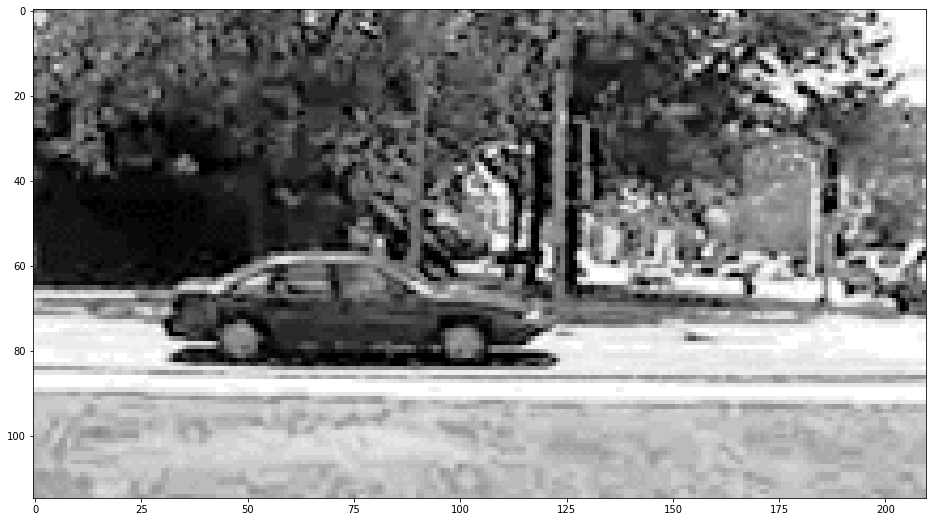

In [17]:
itest = load_image('data/CarData/TestImages/test-0.pgm')
display_image(itest)

Tehnika kojom bi ovo trebalo raditi jeste tzv. klizeći/klizni prozor (eng. <i>sliding window</i>), gde bi se na slici pomerao "prozor", veličine 100 x 40 i za svaki prozor se računao HOG deskriptor i zatim klasifikovao (da li je automobil ili ne). Zatim prozor pomerimo za recimo 10 piksela u desno i uradimo istu stvar. Naravno, kada dođemo do kraja reda, vratimo sliku skroz levo na početak i pomerimo je za recimo 10 piksela na dole i tako dalje.

Ovim ćemo za sve moguće prozore (dimenzija 100 x 40 i sa pomerajima [10px, 0px], [0px, 10px]) dobiti rezultate klasifikacije.

<img src="images/test-im-2.png">

Međutim, ovde nastaje problem - relativno je izvesno da ukoliko smo unutar jednog prozora detektovali automobil, da ćemo i u nekom od susednih prozora detektovati isti taj automobil (prosto, translacijom za samo 10 piksela smo dobili vrlo sličnu sliku i samim tim vrlo sličan HOG deskriptor koji je ulaz u SVM klasifikator). Dakle, neophodno je na neki način spojiti više bounding box-ova u jedan koji će biti konačan rezultat. Treba voditi računa i o slikama koje sadrže više od jednog automobila,a koje su prisutne u testnom skupu podataka. 

Prilikom računanja ovog konačnog bounding box-a može se uzeti u obzir i koliko je SVM siguran (eng. <i>confidence score</i>) u svoju odluku za određeni ulazni podatak - ovu vrednost je moguće dobiti pozivanjem metode <i>predict_proba</i> nad SVM klasifikatorom. Ova metoda vraća verovatnoću ishoda klasifikacije za svaku od klasa. Zbog toga smo u konstruktoru SVM klasifikatora morali staviti <i>probability=True</i>.

<img src="images/test-im-2-nms.png">

Konačni rezultati se mogu proveriti tako što će se uporediti sa lokacijama automobila u <b>data/CarData/trueLocations.txt</b>. U ovoj datoteci, svaka linija počinje sa rednim brojem slike iz testnog foldera, a istinska lokacija automobila na slici je definisana koordinatama gornje leve tačke (oblika: (y,x)) bounding box-a (dato u datoteci), a širina  visina bounding box-a su uvek 100px i 40px, respektivno (kao veličina slika u trening skupu). 

Dakle, ako u datoteci imamo <i>0: (48, 26)</i>, to znači da se na slici <i>data/CarData/TestImages/test-0.pgm</i> automobil nalazi na lokaciji koja je definisana bounding box-om <i>((48, 26), (48+40, 26+100)) = ((48, 26), (88, 126))</i>. Ako se u datoteci nalazi više koordinata u jednoj liniji, to znači da na toj slici ima više automobila.

Metrika kojom se meri poklapanje istinskog bounding box-a i dobijenog bounding box-a je <i>Jaccard index</i>, odnosno <i>IoU (Intersection over Union)</i>. Dakle, za dva bounding box-a, pronaći njihov presek i uniju, a zatim prebrojati piksele u preseku i u uniji i na kraju podeliti ova dva broja:

$$IoU=\frac{|A \cap B|}{|A \cup B|}$$

<img src="images/iou_viz.png">

Ukoliko je poklapanje potpuno, vrednost <i>IoU</i> će biti 1, ako poklapanja nema biće 0, u slučaju delimičnog poklapanja biće neka vrednost između 0 i 1. Vrednosti veće od 0.5 (tj. **IoU > 0.5**) se generalno smatraju "dobrom" predikcijom.
<img src="images/iou_examples.png">

### TODO:  

* Iskoristiti HOG i SVM za detektovanje automobila na slici iz testnog skupa podataka. 

#### Hint za implementaciju:  

* Implementirati metodu koja će računati HOG deskriptor i <i>confidence score</i> SVM klasifikatora za prosleđeni prozor. 
* Implementirati metodu koja će "obilaziti" sliku pomoću klizećeg/kliznog prozora i "pronalaziti" automobile.
* Implementirati metodu koja će računati <i>Jaccard index</i> za dva prosleđena bounding box-a.

# Detekcija karakterističnih tačaka lica - dlib biblioteka

Dlib je javno dostupna biblioteka koja ima veoma široku upotrebu u svim sferama računarstva, napisana je u programskom jeziku C++.
Predstavlja zbirku nezavisnih softverskih komponenti, svaka dolazi uz dokumentaciju i temeljnu podršku za otklanjanje grešaka.

Dlib za detekciju lica koristi histogram orjentisanih gradijenata (HOG), piramidu slika kao i pokretni prozor za detekciju. Ovaj detektor je prilično sveobuhvatan, sa veoma velikom uspešnošću u detektovanju lica sa slike. Više o samoj biblioteci se može pronaći na zvaničnoj [dokumentaciji](http://dlib.net/).

Koraci za instalaciju dlib biblioteke se mogu pronaci na [linku](https://www.pyimagesearch.com/2017/03/27/how-to-install-dlib/)


![alt text](https://www.pyimagesearch.com/wp-content/uploads/2017/04/facial_landmarks_dlib_example.jpg)

**Detekcija karakterističnih tačaka lica se sastoji od:**
1. Lokalizacija lica na slici - pronalaženje pozicije lica i selekcija regiona od interesa 
2. Pronalaženje ključnih tačaka lica

**Detekcija lica se može ostvariti na više načina:**
* OpenCV Haar cascades klasifikator
* HOG + SVM detektor treniran specificno za detekciju lica
* Deep learning rešenja

**Detektori ključnih tačaka lica uglavnom pokušavaju da detektuju sledeće delove lica:**
* usta
* desna obrva
* leva obrva
* desno oko
* levo oko
* vilica


In [18]:
from imutils import face_utils
import numpy as np
import argparse
import imutils
import dlib
import cv2

ModuleNotFoundError: No module named 'imutils'

##### Inicijalizacija detektora i prediktora (Koraci 1 i 2)
Prediktor `shape_predictor_68_face_landmarks.dat` se može preuzeti sa [linka](http://dlib.net/files/)

In [ ]:
# inicijalizaclija dlib detektora (HOG)
detector = dlib.get_frontal_face_detector()
# ucitavanje pretreniranog modela za prepoznavanje karakteristicnih tacaka
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

In [ ]:
# ucitavanje i transformacija slike
image = cv2.imread('./images/example_01.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

Detektor prepoznaje sva lica na slici i vraća listu detektovanih lica. 

In [ ]:
# detekcija svih lica na grayscale slici
rects = detector(gray, 1)

# iteriramo kroz sve detekcije korak 1.
for (i, rect) in enumerate(rects):
    # determine the facial landmarks for the face region, then
    # convert the facial landmark (x, y)-coordinates to a NumPy
    # array
    # odredjivanje kljucnih tacaka - korak 2
    shape = predictor(gray, rect)
    #shape predstavlja 68 koordinata  
    shape = face_utils.shape_to_np(shape) # konverzija u NumPy niz
    print("Dimenzije prediktor matrice: {0}".format(shape.shape)) # 68 tacaka (x,y)
    print("Prva 3 elementa matrice")
    print(shape[:3]) 

    # konvertovanje pravougaonika u bounding box koorinate
    (x, y, w, h) = face_utils.rect_to_bb(rect)
    # crtanje pravougaonika oko detektovanog lica
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # ispis rednog broja detektovanog lica
    cv2.putText(image, "Face #{}".format(i + 1), (x - 10, y - 10),
    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # crtanje kljucnih tacaka
    for (x, y) in shape:
        cv2.circle(image, (x, y), 1, (0, 0, 255), -1)

Prikaz slike

In [ ]:
plt.imshow(image)

### dlib detektor - razumevanje karakterističnih tačaka
Pretrenirani dlib detektor predviđa lokaciju (x,y koordinate) 68 karakterističnih tačaka lica, čiji raspored je prikazan na slici ispod.

![tacke](https://www.pyimagesearch.com/wp-content/uploads/2017/04/facial_landmarks_68markup-768x619.jpg)


Problemi koje možete da rešite pomoću dlib biblioteke:
* Detekcija i klasifikacija lica
* Detekcija emocija lica
* Zamena lica
* Detekcija umora
